# This Notebook Describes Classification of DM and Pulsar <br>  using Machine Learning Techniques, with Background Fit Parameters <br> to Simulated CALET Data as Features.  

### Pre-requisites 

#### _Methods_

* Find DM models that can explain the CALET data (here I've used [CALET 1st results](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.181101)).  

* The background parametrization for electron spectrum is assumed to be broken power-law with expoenential cut-off 
    $\phi _{e^{-}} = C_{e^{-}}\,  E^{\gamma _ {e ^{-}} - \Delta \gamma _ {e ^{-}}}\left(1+\left(\frac{E}{E_g}\right)^{\frac{\Delta \gamma _{e ^{-}}}{s}}\right)^s \, \left(\frac{C_s}{C_{e^{-}}}\, E^{\delta}\,+\, e^{-\frac{E}{E_d}}\right)$

* Simulate CALET data assuming full exposure and 5 years of observation, with the best fit DM model as extra source.

* Fit the pulsar model to the 5000 simulated data, and re-fit the DM model to the same points. 

* Create .csv files from the fit information for both DM and pulsar
    * .csv files are necessary for handling using [PANDAS library](https://pandas.pydata.org/). 
    * Label the DM samples as 1 and pulsar samples as 0 using Pandas. 
    * Concatenate the two dataframes and the final file is ready to use

#### _Libraries_

* Only python libraries are used for the complete analysis. (Python 3 is better!)
    
    * [matplotlib](https://matplotlib.org/)
    * [Numpy](http://www.numpy.org/)
    * [scipy](https://www.scipy.org/)
    * [pandas](https://pandas.pydata.org/)
    * [seaborn](https://seaborn.pydata.org/)
    * [scikit learn](https://scikit-learn.org/stable/)

In [19]:
#import libraries 
import math
import time
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as stats
import pandas as pd 
import numpy as np
#print (np.__version__)
#
import warnings
warnings.filterwarnings("ignore")

# import Machine Learning Tools from scikit-learn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

start_t = time.time()

In [20]:
DM_df = pd.read_csv('DM_pul_ModelB_PCA_col_name.csv')
print (DM_df.head(3))

       frac   phi        Eg       dge     Ed     s        Ce       ge   Y
0  0.233887   0.5  107.7091  0.708383   5000  0.95  0.827184  2.82353   1
1  0.233718   0.5  111.6189  0.671443  10000  0.95  0.817695  2.85904   1
2  0.216424   0.5  119.5396  0.630670  10000  0.80  0.877305  2.87420   1


### Shuffle the dataframe, as all the first 5000 rows are DM sample and remaining are pulsars

In [21]:
DM_df_mix = DM_df.sample(frac=1)
print (DM_df_mix.head(5))

          frac   phi        Eg       dge     Ed     s        Ce       ge   Y
6323  0.223340  0.45  153.1422  0.595066   7000  0.85  0.854123  2.88350   0
2107  0.233993  0.50  107.0104  0.687873   7000  0.95  0.818851  2.84733   1
8969  0.221196  0.55   93.1168  0.597763  10000  0.75  0.878698  2.93273   0
7489  0.197030  0.40  179.9621  0.517248   7000  0.55  0.939739  2.89139   0
4603  0.223994  0.45  141.7631  0.662488   5000  0.90  0.849650  2.82505   1


######  Parameters are $\frac{C_s}{C_{e^-}}, \phi , E_g, \delta\gamma _{e^-}, E_d, s, C_{e^-}, \gamma _{e^-}$ <br>
1 denotes DM and 0 denotes pulsar

### Seperate data into features and label

In [22]:
X_feat = DM_df_mix.iloc[:, 0:8]
print ("feature type: ", type(X_feat))
print ("feature.shape: ", X_feat.shape)
#print ("data types of features: ", X_feat.dtypes)
X_feat = X_feat.astype('float64')
print ("data types of features: ", X_feat.dtypes)
Y_lab = DM_df_mix.iloc[:, 8:9]
print ("label shape: ", Y_lab.shape)
print ("label type: ", type(Y_lab)) 
Y_lab_list = Y_lab.values.tolist()
print (type(Y_lab_list))
yl= [int(target) for [target] in Y_lab_list] 

('feature type: ', <class 'pandas.core.frame.DataFrame'>)
('feature.shape: ', (10151, 8))
('data types of features: ', frac    float64
 phi    float64
 Eg     float64
 dge    float64
 Ed     float64
 s      float64
 Ce     float64
 ge     float64
dtype: object)
('label shape: ', (10151, 1))
('label type: ', <class 'pandas.core.frame.DataFrame'>)
<type 'list'>


### Check correlation plots for some parameters

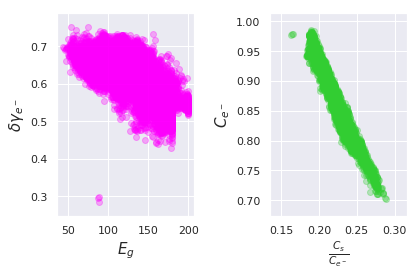

In [23]:
plt.subplot(1,2,1)
plt.scatter(X_feat.iloc[:, 2], X_feat.iloc[:, 3], color='magenta', alpha=0.3)
plt.xlabel(r'$E_g$', fontsize=15)
plt.ylabel(r'$\delta\gamma _{e^-}$', fontsize=15)
plt.subplot(1,2,2)
plt.scatter(X_feat.iloc[:, 0], X_feat.iloc[:, 6], color='limegreen', alpha=0.3)
plt.xlabel(r'$\frac{C_s}{C_{e^-}}$', fontsize=15)
plt.ylabel(r'$C_{e^-}$', fontsize=15)
plt.tight_layout()
plt.show()

##### makes sense as there's a strong correlation between the ratio of positron/electron normalization <br> to electron normalization 

###  Brief into to Exploratory Data Analysis
#### Use Seaborn Joint plot to create Scatter plot with Marginal Histogrmas.  

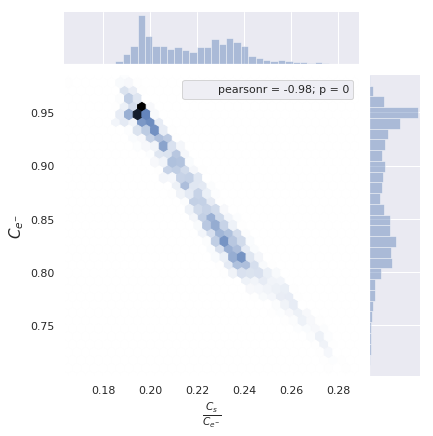

In [24]:
%matplotlib inline
columns1 = ['fr','phi','Eg','dge','Ed','s','Ce','ge','Label']
#print columns1
DM_df_mix.columns = columns1
#print DM_df_mix.columns
sns.set(font_scale=1)
g=sns.jointplot(x="fr", y="Ce", data=DM_df_mix, kind='hex') 
g.annotate(stats.pearsonr)
g.set_axis_labels(r'$\frac{C_s}{C_{e^{-}}}$', r'$C_{e ^{-}}$', fontsize=15)

### Use Seaborn to Visualize Few Pair Plots and See Distribution of DM and Pulsar Samples  

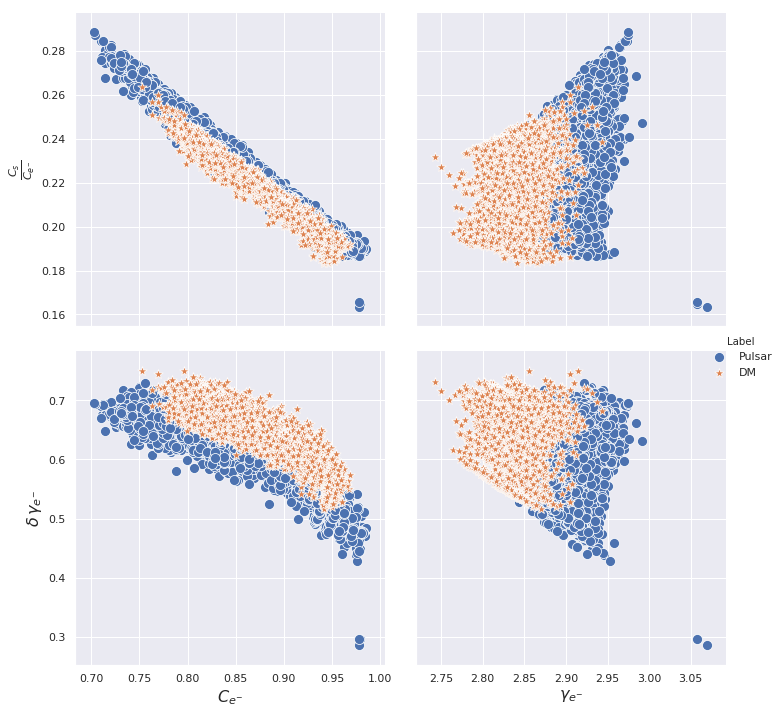

In [25]:
#### Seaborn Pair plots 

replacements = {'Ce': r'$C_{e^{-}}$', 'ge': r'$\gamma _{e^{-}}$',
                'dge': r'$\delta \, \gamma _{e^{-}}$', 'fr': r'$\frac{C_s}{C_{e^{-}}}$', '1':'DM', '0':'Pulsar'}


h = sns.pairplot(DM_df_mix,
                 x_vars=["Ce", "ge"],
                 y_vars=["fr", "dge"], hue='Label', height=5, markers=['o', '*'], 
                 plot_kws=dict(s=100))




for ix in range(2):
    for jy in range(2):
        xlabel = h.axes[ix][jy].get_xlabel()
        ylabel = h.axes[ix][jy].get_ylabel()
        if xlabel in replacements.keys():
            h.axes[ix][jy].set_xlabel(replacements[xlabel], fontsize=16)
        if ylabel in replacements.keys():
            h.axes[ix][jy].set_ylabel(replacements[ylabel], fontsize=16)
            
for ixx in range(len(h.fig.get_children()[-1].texts)):
    label = h.fig.get_children()[-1].texts[ixx].get_text()
    if label in replacements.keys():
        h.fig.get_children()[-1].texts[ixx].set_text(replacements[label])         

        
# Thanks to http://catherineh.github.io/programming/2016/05/24/seaborn-pairgrid-tips        

### Preparing to Use Machine Learning Algorithms

#### Separate Training and  Test Samples; I've used 25% Samples as Test Data 

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X_feat, Y_lab, test_size=0.25, random_state=30)
print "training data type: ", type(X_train)
print "training features' shape: ", X_train.shape
print "test features' shape: ", X_test.shape

training data type:  <class 'pandas.core.frame.DataFrame'>
training features' shape:  (7613, 8)
test features' shape:  (2538, 8)


### Preparing the pipeline steps with <br>

*  Normalization of the features with standardscaler
*  Applying Principal Component Analysis 
*  Use Support Vector Machine Algorithm to Classify DM and Pulsar Samples

In [27]:
# define the Steps
steps = [('scaler', StandardScaler()), ('pca', PCA()), ('svm', SVC())]

#before applying pipeline just test the pca method 

scaler1 = StandardScaler()
scaler1.fit(X_feat)
X_scaled_feat = scaler1.transform(X_feat)
print ("After scaling features type: ", type(X_scaled_feat))
print ("After scaling features array shpae: ", X_scaled_feat.shape)

#print (X_scaled_feat.max(axis=0))

pca1 = PCA(n_components=4) # Output Shape will now have (n_components) attributes (features)  
pca1.fit(X_scaled_feat)
X_scaled_feat_pca = pca1.transform(X_scaled_feat)
print (np.shape(X_scaled_feat_pca)) # 4 principal components

('After scaling features type: ', <type 'numpy.ndarray'>)
('After scaling features array shpae: ', (10151, 8))
(10151, 4)


### Plot the data and check the effect of PCA; here we have 4 Principal Components 

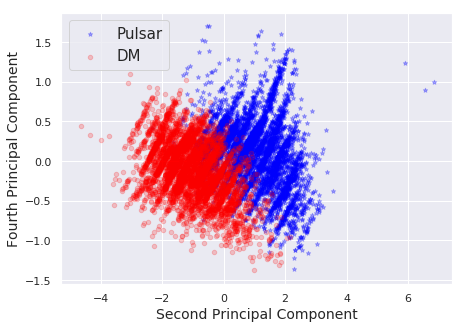

In [28]:
Xax=X_scaled_feat_pca[:,1]
Yax=X_scaled_feat_pca[:,3]
labels=yl
cdict={0:'blue',1:'red'}
labl={0:'Pulsar',1:'DM'}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.2}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],label=labl[l],s=20,marker=marker[l],alpha=alpha[l])




plt.xlabel("Second Principal Component",fontsize=14)
plt.ylabel("Fourth Principal Component",fontsize=14)

plt.legend(fontsize=15)


plt.show()

### We will use Grid Search Cross Validation method to determine <br>

*  Number of principal components for PCA (Number of Components is fixed to 2 here)
*  Support vector machine C parameter 
*  Support vector machine gamma parameter <br>

PCA and SVM both needs standardization of features, so all these components will be part of a pipeline 

For SVM Radial Basis Kernel gives the best score and takes least time 

Radial basis function kernel is defined as-- 
$ K(x_i, x_j) = \text{exp}\, \left(-\frac{\left|x_i-x_j\right|^2}{2\sigma ^2}\right)$

In [29]:
# Steps in the pipeline will be standardscaler, pca and svm 

pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('supVMac', SVC(kernel='rbf'))] 
# if you want to wait forever, try polynomial kernel 
Check_params = {
    'pca__n_components': [2],
    'supVMac__C': [0.1, 1, 100, 1000],
    'supVMac__gamma': [0.07, 0.7, 7, 70]
    }

pipeline = Pipeline(pipe_steps)

### After setting up the pipeline it's time to set up the GridSearchCV

In [30]:
grid = GridSearchCV(pipeline, param_grid=Check_params, cv=5)
grid.fit(X_train, Y_train)





print "score = %3.2f" %(grid.score(X_test, Y_test))


print "best parameters for PCA and SVM: ", grid.best_params_


print ("SVM_C parameter: ", grid.best_params_['supVMac__C'])
print (type(grid.best_params_['supVMac__C']))

score = 0.92
best parameters for PCA and SVM:  {'pca__n_components': 2, 'supVMac__gamma': 7, 'supVMac__C': 100}
('SVM_C parameter: ', 100)
<type 'int'>


### 92% Accuracy on Test Data for $C = 100, \gamma = 7$

In [31]:
#prediction time 

Y_pred = grid.predict(X_test)

print Y_pred[200:215]
print Y_test[200:215]

[1 0 0 0 0 1 1 1 0 0 0 0 0 0 1]
       Y
4168   1
5289   0
4000   1
7433   0
6517   0
4601   1
5590   0
871    1
7141   0
8026   0
9426   0
6586   0
5323   0
373    1
2548   1


### Confusion Matrix 

#### Confusion matrix for binary classification like here will have 4 elements
*  $C_{0,0}$ is true negative (Actual label = 0 = Predicted label)
*  $C_{1,0}$ is false negative (Actual label = 1, Predicted label = 0)
*  $C_{0,1}$ is false positive (Actual label = 0, Predicted label = 1)
*  $C_{1,1}$ is true positive (Actual label = 1 = Predicted label)

In [41]:
print "confusion matrix: \n ", confusion_matrix(Y_test, Y_pred)

confusion matrix: 
  [[1181  101]
 [ 102 1154]]


### Plot the Decision Boundary

after scaling minimum [-2.76061982 -1.86708094 -2.60862805 -4.94134313 -2.08045407 -3.60245637
 -2.90988527 -2.98963417]
('shape of X0: ', (2538,))
('shape of X1: ', (2538,))


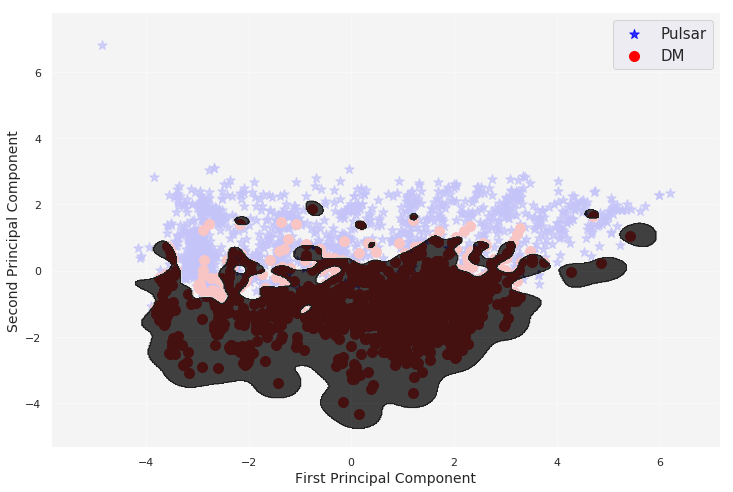

In [43]:
scaler1=StandardScaler()#instantiate
scaler1.fit(X_test) # compute the mean and standard which will be used in the next command
X_scaled=scaler1.transform(X_test)# fit and transform can be applied together and I leave that for simple exercise
# we can check the minimum and maximum of the scaled features which we expect to be 0 and 1
print "after scaling minimum", X_scaled.min(axis=0) 








pca1 = PCA(n_components=2)
Xreduced = pca1.fit_transform(X_scaled)
#shape1 = Xreduced[:,0].shape
#print ("shape of PCA array: ", Xreduced.shape)
##print ("shape of 0th column: ",Xreduced[:, 0].reshape(shape1[0], -1))
#print ("type of 0th column: ", type(Xreduced[:,0]))


model = SVC(kernel='rbf', C = float(grid.best_params_['supVMac__C']), gamma=float(grid.best_params_['supVMac__gamma']))
classf = model.fit(Xreduced, Y_test)




def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out




def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

print ("shape of X0: ", X0.shape)
print ("shape of X1: ", X1.shape)

fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_facecolor('white')
cdict1={0:'blue',1:'red'}

Y_tar_list = Y_test.values.tolist()
yl1= [int(target1) for [target1] in Y_tar_list]
labels1=yl1
 

labl1={0:'Pulsar',1:'DM'}
marker1={0:'*',1:'o'}
alpha1={0:.8, 1:1}


for l1 in np.unique(labels1):
    ix1=np.where(labels1==l1)
    ax.scatter(X0[ix1],X1[ix1],c=cdict1[l1],label=labl1[l1],s=100,marker=marker1[l1],alpha=alpha1[l1])

plot_contours(ax, classf, xx, yy,cmap='Greys', alpha=0.8)
plt.legend(fontsize=15)

#ax.scatter(X0, X1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
#ax.set_xlim(xx.min(), xx.max())
#ax.set_ylim(yy.min(), yy.max())
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)

plt.savefig('ClassifyDMMOdelB_Pulsar.png', dpi=400)
plt.show()

In [ ]:
endt = time.time()
print ("total time taken :", endt - start_t)

### 92% Accuracy is Obtained Using SVM with RBF Kernel. 